<h1 style = "color: green"> Esercitazione 12 </h1>

<h3 style = "color: blue"> Esercizio 12.1 </h3>

Vogliamo creare e allenare una rete neurale per riconoscere cifre scritte "a mano", contenute in un'immagine $28\times 28px$. I dati per addestrare la rete sono contenuti nel database MNIST: usiamo 60000 immagini come allenamento e le restanti 10000 come test.  

Per prima cosa vogliamo capire qual è l'algoritmo di ottimizzazione migliore, cioè quello che a parità di epoche e dati di allenamento porta a un'accuratezza migliore. Per questa analisi sfruttiamo il modello fornito: manteniamo la stessa struttura degli strati e fissiamo il numero di epoche a 50. Questo perché, studiando accuratezza e loss per la rete neurale fornita, notiamo che durante l'allenamento questi valori migliorano (l'accuratezza sale e la loss scende) fino a 100 epoche, mentre durante il test si stabilizzano attorno a un valore costante dopo circa 30 epoche. Scegliamo quindi una via di mezzo.

Le reti neurali usate in questo esercizio sono create e addestrate in un file separato, salvate e caricate qui. Sono formate da tre "dense layers", il primo che riceve in input i $28\times 28$ pixel dell'immagine e ha 400 neuroni, il secondo da 100 neuroni che è collegato, attraverso uno strato di dropout, allo strato di output da 10 neuroni.

Per prima cosa analizziamo la rete già disponibile, cioè quella con lo stochastic gradient descent (SGD) come algoritmo di ottimizzazione.

In [29]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)



from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)



from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

In [30]:
def loadNetAndHistory(path):
    model = tf.keras.models.load_model(filepath = path + ".h5")
    history = np.load(path + ".npy", allow_pickle = "TRUE").item()
    print("Model loaded")
    return model, history



def saveNetAndHistory(path, model, history):
    model.save(filepath=path + ".h5", include_optimizer=True)
    np.save(path + ".npy", history.history)
    return
    

    
    
def evaluateModel(model, history):
    # evaluate model
    score = model.evaluate(X_test, Y_test, verbose=1)

    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # look into training history (saved together with the model)

    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.ylabel('model accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.grid(True)
    plt.show()

    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.grid(True)
    plt.show()
    
    return

Model loaded
313/313 [==============================] - 1s 2ms/step - loss: 0.0594 - acc: 0.9820

Test loss: 0.059352628886699677
Test accuracy: 0.9819999933242798


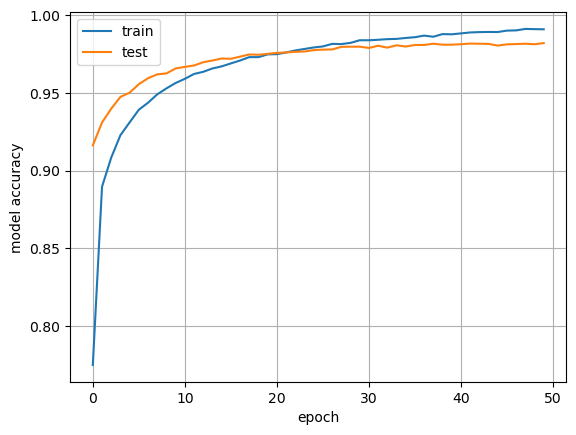

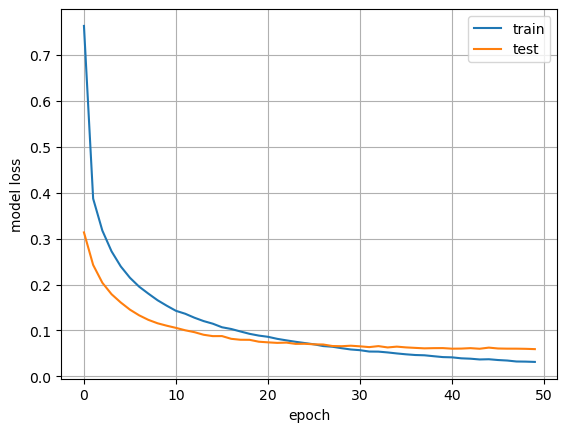

In [31]:
modSGD, histSGD = loadNetAndHistory("NNs/test_SGD")
evaluateModel(modSGD, histSGD)

Con SGD otteniamo una buona precisione del $98\%$.  

Nell'esercitazione precedente, il miglior ottimizzatore risultava essere "adam". Verifichiamo se è così anche in questo caso.

Model loaded
313/313 [==============================] - 1s 2ms/step - loss: 0.2120 - acc: 0.9819

Test loss: 0.21202848851680756
Test accuracy: 0.9818999767303467


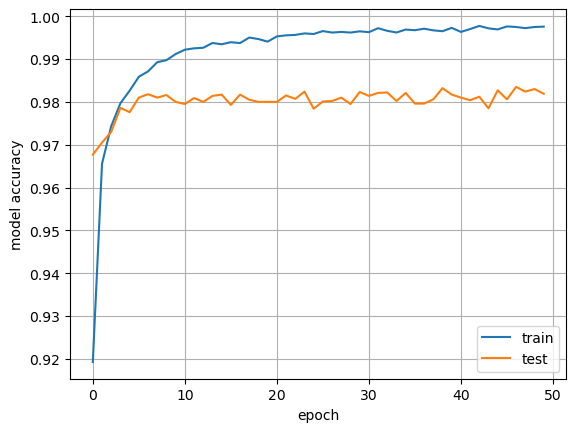

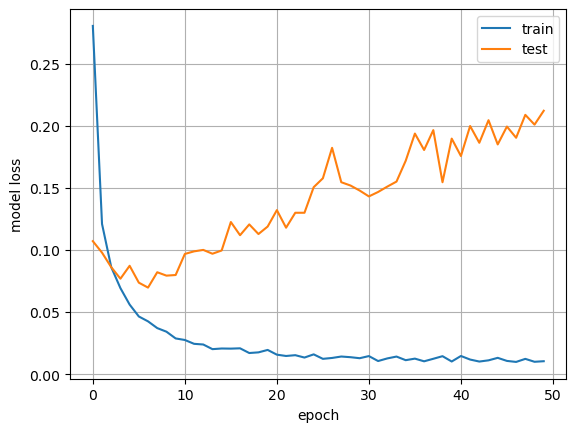

In [32]:
modAdam, histAdam = loadNetAndHistory("NNs/test_adam")
evaluateModel(modAdam, histAdam)

L'accuratezza massima è molto simile al caso precedente ed è raggiunta dopo meno di 10 epoche, ma vediamo che la loss del test aumenta all'aumentare delle epoche, forse per via di un overfitting. Nel minimo resta comunque maggiore di prima. In questo caso scartiamo quindi "adam".  

Proviamo ora l'algoritmo "adagrad".

Model loaded
313/313 [==============================] - 1s 2ms/step - loss: 0.1479 - acc: 0.9555

Test loss: 0.1479398012161255
Test accuracy: 0.9555000066757202


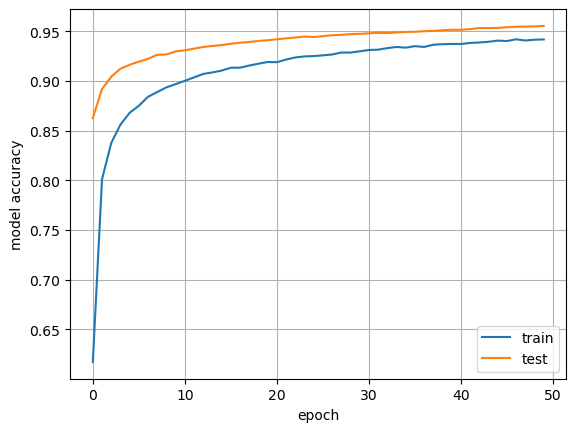

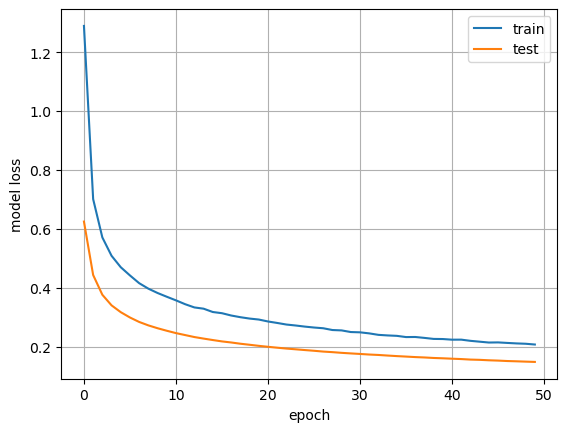

In [33]:
modAgrd, histAgrd = loadNetAndHistory("NNs/test_adagrad")
evaluateModel(modAgrd, histAgrd)

Con questo modello le due funzioni del test sono sempre migliori di quelle dell'allenamento (anche perché usando uno strato di dropout, questo risultato è atteso), ma sono peggiori rispetto agli altri due casi.  

Proviamo infine "adadelta", che è una versione migliorata di "adagrad".

Model loaded
313/313 [==============================] - 1s 2ms/step - loss: 0.3419 - acc: 0.9143

Test loss: 0.34191185235977173
Test accuracy: 0.9143000245094299


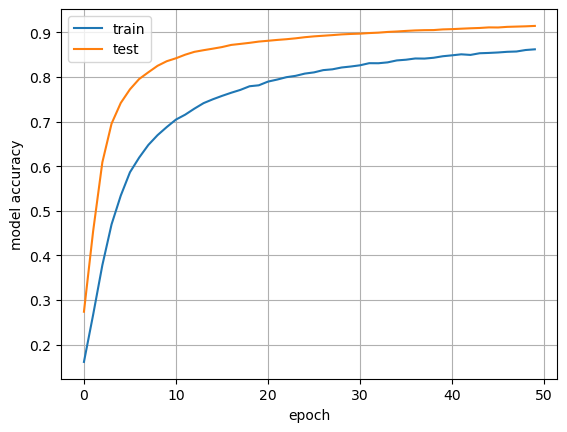

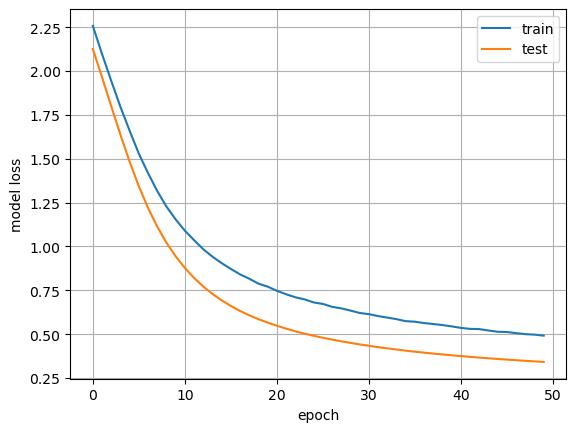

In [34]:
modAdad, histAdad = loadNetAndHistory("NNs/test_adadelta")
evaluateModel(modAdad, histAdad)

"adadelta" risulta essere il peggior algoritmo fin'ora, con un andamento dei due valori simile ad "adagrad".

Per il resto dell'esercitazione useremo quindi l'algoritmo SGD.

<h3 style = "color: blue"> Esercizio 12.2 </h3>

Aggiungiamo ora alla rete neurale altri tipi di strati, in modo che sia in grado di riconoscere pattern in 2D e migliorare quindi l'accuratezza.  
In questo caso ci interessa solo la capacità predittiva della rete; possiamo quindi diminuire le epoche di allenamento a 25, cioè dove l'accuratezza e la loss del test si stabilizzano.

In [35]:
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    


# function to create a basic CNN
def create_CNN0():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

In [36]:
# training parameters
batch_size = 32
epochs = 25

In [37]:
# we used this to create and train the CNN loaded below

#model_CNN = create_CNN0()

# train CNN
#history = model_CNN.fit(X_train, Y_train,
#          batch_size=batch_size,
#          epochs=epochs,
#          verbose=1,
#          validation_data=(X_test, Y_test))

#saveNetAndHistory("NNs/CNN_basic", model_CNN, history)

In [38]:
modelBasic, historyBasic = loadNetAndHistory("NNs/CNN_basic")

Model loaded


313/313 [==============================] - 1s 2ms/step - loss: 0.0423 - acc: 0.9869

Test loss: 0.04227634146809578
Test accuracy: 0.9868999719619751


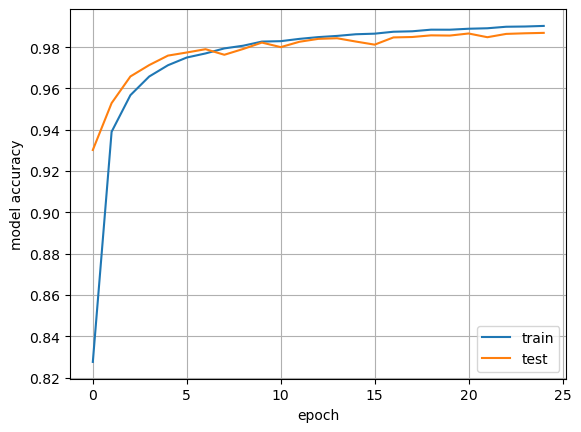

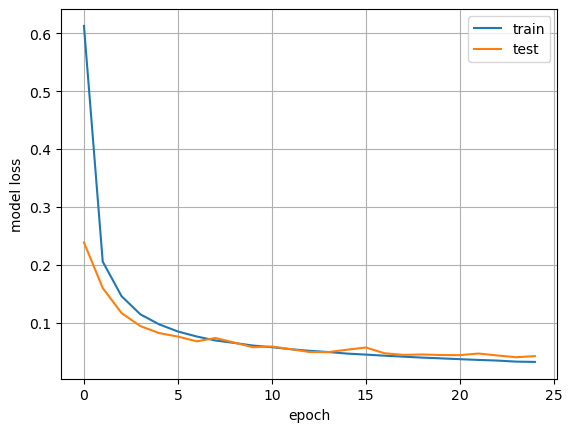

In [39]:
evaluateModel(modelBasic, historyBasic)

Con un solo strato convoluzionale e senza strati di dropout otteniamo già un'accuratezza del $98.7\%$.  
Riportiamo la predizione di alcune cifre, che in questo caso sono tutte corrette.

313/313 [==============================] - 1s 2ms/step


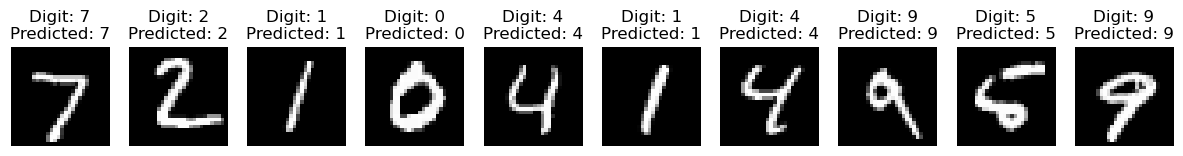

In [40]:
predictions = modelBasic.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Creiamo ora una rete convoluzionale più sofisticata, aggiungendo anche uno strato di dropout.

In [41]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

In [42]:
# we used this to create and train the CNN loaded below

#model_CNN = create_CNN()

# train CNN
#history = model_CNN.fit(X_train, Y_train,
#          batch_size=batch_size,
#          epochs=epochs,
#          verbose=1,
#          validation_data=(X_test, Y_test))

#saveNetAndHistory("NNs/CNN_final2", model_CNN, history)

In [43]:
modelFinal, historyFinal = loadNetAndHistory("NNs/CNN_final2")

Model loaded


313/313 [==============================] - 1s 3ms/step - loss: 0.0305 - acc: 0.9904

Test loss: 0.030474144965410233
Test accuracy: 0.9904000163078308


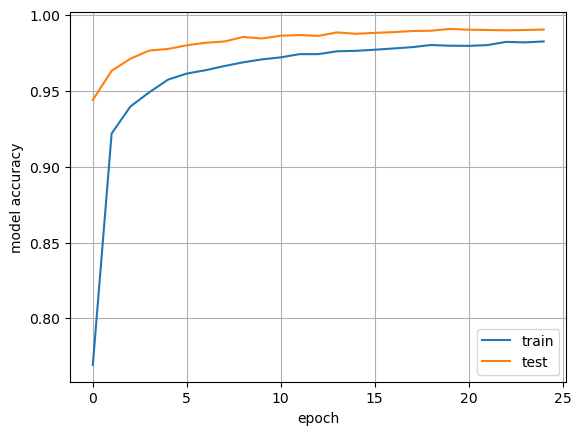

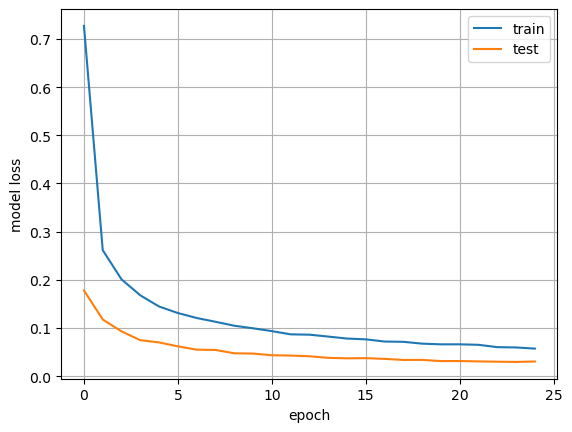

In [44]:
evaluateModel(modelFinal, historyFinal)

Con questo modello riusciamo a raggiungere un'accuratezza del $99\%$, che è di poco migliore del caso precedente, con una miglior loss (circa il $25\%$ minore). Tuttavia in questo caso abbiamo applicato un layer di dropout, che dovrebbe rendere il modello più robusto quando messo a confronto con immagini esterne al set di allenamento.  

Anche questo modello predice correttamente le 10 cifre precedenti.

313/313 [==============================] - 1s 2ms/step


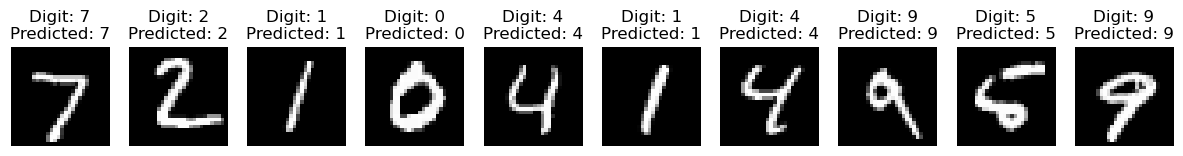

In [45]:
predictions = modelFinal.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

<h3 style = "color: blue"> Esercizio 12.3 </h3>

Mettiamo alla prova la rete neurale precedente con cifre scritte da noi.

In [46]:
# load images
from PIL import Image

nDigits = 10
xdim, ydim = 28, 28
data = np.zeros((nDigits, xdim, ydim))

for dig in range(nDigits):
    digit_filename = "Pictures/" + str(dig) + ".png"
    digit_in = Image.open(digit_filename).convert('L')

    pix=digit_in.load();
    
    for j in range(ydim):
        for i in range(xdim):
            data[dig, i, j] = pix[j, i]

data /= 255

1/1 [==============================] - 0s 23ms/step


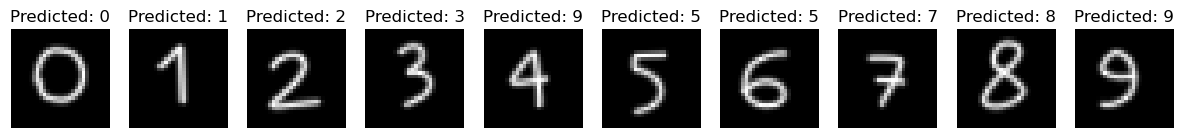

In [47]:
data = data.reshape(data.shape[0], xdim * ydim)

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    data = data.reshape(data.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    data = data.reshape(data.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


predictions = modelFinal.predict(data)

data = data.reshape(data.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(nDigits):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data[i, :, :, 0], cmap='gray')    
    plt.title("Predicted: {}".format(np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

La rete commette due errori in questo caso: invece del 4 predice un 9 e invece del 6 un 5. Il primo errore era piuttosto atteso, visto come scrivo il 4; mentre il secondo è piuttosto sorprendente.  

Visto che l'abbiamo già creata, possiamo vedere come si comporta anche la rete più semplice.

1/1 [==============================] - 0s 30ms/step


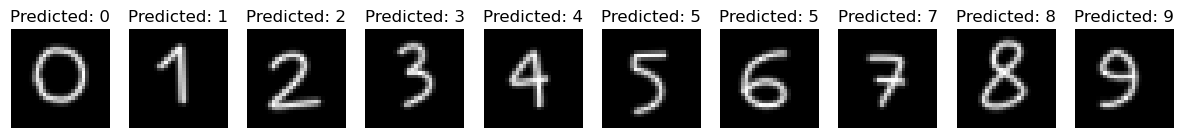

In [48]:
data = data.reshape(data.shape[0], xdim * ydim)

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    data = data.reshape(data.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    data = data.reshape(data.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


predictions = modelBasic.predict(data)

data = data.reshape(data.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(nDigits):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(data[i, :, :, 0], cmap='gray')    
    plt.title("Predicted: {}".format(np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Questa rete predice correttamente il 4 ma sbaglia di nuovo il 6. Osservando i risultati dell'esercizio 12.2, notiamo che in quel caso entrambe le reti predicono correttamente un 5 che potrebbe anche sembrare un 6. Quindi anche questo errore potrebbe essere dovuto a differenze tra la mia scrittura e quella delle cifre nel database.